In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH  = '../resources/model_results/random_forest_grid.npy'
MODEL_PATH  = '../resources/best_models/random_forest.npy'
TRAIN_MODEL = False

# Random Forest Model

### Load the data

In [4]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

Decision trees tend to have low bias but high variance, the cause of their apparant lack of robustness. Random forest reduces this variance. It achieves it by bootstraping the training data and building one tree from each bootstraped dataset. Each tree will predict a class for a test data point and the most-frequent predicted class will be the one given to the point. As a result, random forest reduces the variance without bias trade-off but at the expense of the model interpretability. This approach is called bagging. Moreover, each tree split can be done only on a randomly drawn subset of the predictors. As a result, random forest build a forest of heterogeneous/decorralated trees; the strongest predictors are not always at the top of the trees.

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components 
* Number of trees
* Maximum depth of the trees
* Number of features to consider when looking for the best split

Note that because the imbalance of our target variable, we apply weights inversely proportional to class frequencies: `class_weight='balanced'`.

In [5]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]
rf__n_estimators = [10, 25, 50, 100, 250, 500, 1000]
rf__max_depth = [3, 5, 10, 15, 20, None]
rf__max_features = [0.25, 1/3, 0.5, 2/3, 0.75]
   
# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('rf', RandomForestClassifier(criterion='gini', class_weight='balanced', random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'rf__n_estimators': rf__n_estimators,
        'rf__max_depth': rf__max_depth,
        'rf__max_features': rf__max_features
    })
    
    # Scorers
    average_precision_scorer = make_scorer(average_precision_score, 
                                           greater_is_better=True, 
                                           needs_proba=False,
                                           needs_threshold=True)
    
    roc_auc_scorer = make_scorer(roc_auc_score, 
                                 greater_is_better=True, 
                                 needs_threshold=True)
    
    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': roc_auc_scorer,
            'average_precision': average_precision_scorer
        },
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [6]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('n_estimators', r['param_rf__n_estimators']),
    ('max_depth', r['param_rf__max_depth']),
    ('max_features', r['param_rf__max_features']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)
df.max_depth.fillna(99, inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 1050


,n_components,n_estimators,max_depth,max_features,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,10,3,0.25,0.800644,0.792983,0.007661,0.007618,0.022143
1,9,25,3,0.25,0.798402,0.784857,0.013546,0.007538,0.023079
2,9,50,3,0.25,0.792696,0.777900,0.014796,0.009615,0.024643
3,9,100,3,0.25,0.790806,0.778030,0.012775,0.008873,0.024365
4,9,250,3,0.25,0.788252,0.782220,0.006032,0.007991,0.021634


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

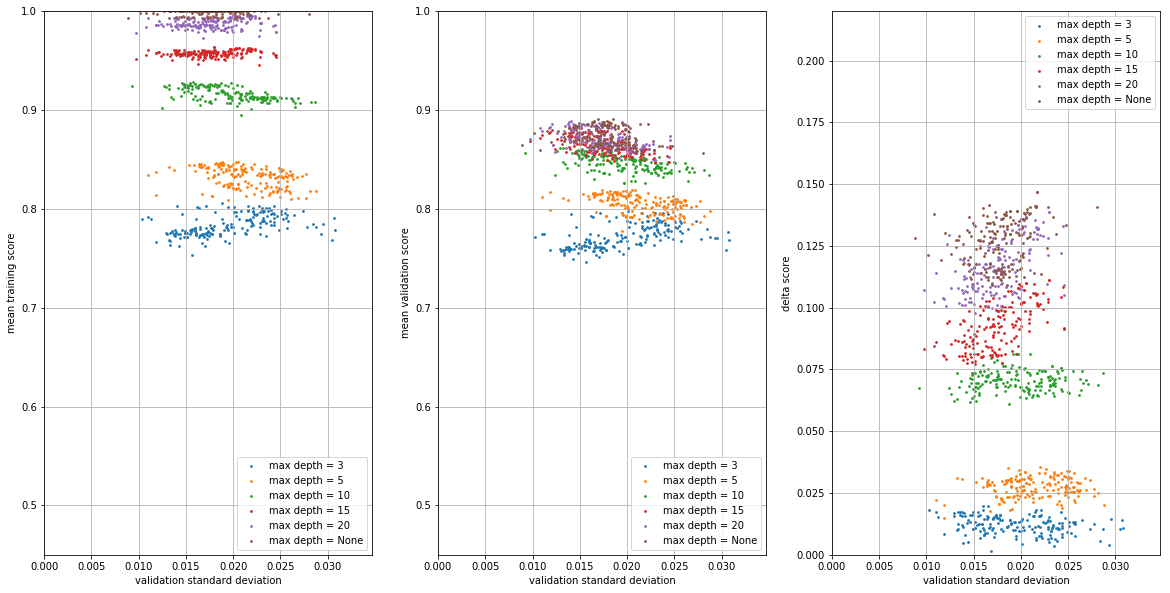

In [7]:
# Selection filters
depth_filter = (df.max_depth == 10)
feature_filter = (df.max_features >= 0.5)

# Plot vars
legend_loc = ['lower right', 'lower right', 'upper right']
ylabel = ['mean training score', 'mean validation score', 'delta score']
ylims = [(0.45, 1), (0.45, 1), (0, 0.22)]

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[df.max_depth == 3], df.loc[df.max_depth == 3, var], color='C0', label='max depth = 3', s=3)
    ax[i].scatter(df.std_valid_score[df.max_depth == 5], df.loc[df.max_depth == 5, var], color='C1', label='max depth = 5', s=3)
    ax[i].scatter(df.std_valid_score[df.max_depth == 10], df.loc[df.max_depth == 10, var], color='C2', label='max depth = 10', s=3)
    ax[i].scatter(df.std_valid_score[df.max_depth == 15], df.loc[df.max_depth == 15, var], color='C3', label='max depth = 15', s=3)
    ax[i].scatter(df.std_valid_score[df.max_depth == 15], df.loc[df.max_depth == 20, var], color='C4', label='max depth = 20', s=3)
    ax[i].scatter(df.std_valid_score[df.max_depth == 99], df.loc[df.max_depth == 99, var], color='C5', label='max depth = None', s=3)

    
    
    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, ax[i].get_xlim()[1]), ylim=ylims[i])
    ax[i].legend(loc=legend_loc[i])
    i += 1

plt.show()

The overfitting induced by the increase of the maximum tree depth is clearly visible and form clusters. It appears that the best models should have a maximum depth of at least 10 and that above a depth of 20, we can't really expect better precision score but more overfitting.

Most of the models have a standard deviation between 1% and 3%. It's okish but a rule of thumb say that it's generally not good enough for production. Good models should have validation standard deviation less than 1%.

Given the results, our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1%
* mean validation precision >= 85%

In [8]:
# Model selection according to some wished criteria
f_std_valid = (df.std_valid_score <= 0.01)
f_valid_score = (df.mean_valid_score >= 0.85)

filter =  f_std_valid & f_valid_score
best_models = df[filter].sort_values(by='std_valid_score', ascending=True)
best_models

,n_components,n_estimators,max_depth,max_features,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
350,12,10,20,0.25,0.982551,0.866985,0.115565,0.004427,0.008102
385,12,10,99,0.25,0.993098,0.864960,0.128138,0.002152,0.008837
927,21,100,10,0.5,0.924117,0.856680,0.067437,0.002527,0.009256
735,18,10,15,0.25,0.951854,0.868387,0.083467,0.006423,0.009703


Except the second model that bring no advantage over the first one, each others could be selected with good reason:

* the first one has the lowest validation standard deviation, 87% validation score, 98% training score
* the third one has a lower 86% validation score, but less overfitting because its 92% training score
* the last one is in between with a slighlty better 87% validation score and 95% training score

We will choose the first model as the best one.  
I tend to think that choosing the lowest validation strandard deviation is the way to go as soon as the mean validation score is near the best score.

### Best model evaluation on the test set

We must now to train these model on the full training set and evaluate it on the test set :

In [9]:
# Best model hyperparameters
pca__n_components = best_models.n_components.values[0]
rf__n_estimators = best_models.n_estimators.values[0]
rf__max_depth = best_models.max_depth.values[0]
rf__max_features = best_models.max_features.values[0]

if TRAIN_MODEL:
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca__n_components, random_state=0)),
        ('rf', RandomForestClassifier(n_estimators=rf__n_estimators,
                                      max_depth=rf__max_depth,
                                      max_features=rf__max_features,
                                      criterion='gini', 
                                      class_weight='balanced', 
                                      random_state=0))
    ])
    pipe.fit(X_train, y_train)

    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)
else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)    

In [10]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('Random Forest Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('Random Forest Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
Random Forest Precision (training set):  0.968
Random Forest Precision (test set) :  0.887


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	487 (TN)	 58 (FN)
Predicted P	 40 (FP)	313 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.887
Recall    :  0.844
Accuracy  :  0.891
F1 Score  :  0.865


The training and test precision scores are closer and better than expected by cross-validation. The overfitting remains acceptable given the nature of the model.
  
This model is clearly better than the baseline models and an improvement over our best decision tree model.  
With a precision score of 89% and a recall of 84%, it appears to be a well balanced model.